In [19]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from PIL import Image
import random
from collections import defaultdict
from models_arch import ResidualBlock, BetterCNNWithResiduals, SmallCNN

#### Подбираем значения mean и std для нормализации
  
[ссылка про нормализацию](https://ru.stackoverflow.com/questions/1218189/%D0%9A%D0%B0%D0%BA%D0%B8%D0%B5-%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%8B-%D0%BD%D0%B0%D0%B4%D0%BE-%D0%BF%D0%B5%D1%80%D0%B5%D0%B4%D0%B0%D1%82%D1%8C-%D0%B2-transforms-normalize?ysclid=m9sh2cirgu756686841)

In [20]:
mean = torch.tensor([0.0070, 0.0069, 0.0065])
std = torch.tensor([0.0036, 0.0035, 0.0035])

calculate_normalize = False

In [3]:
if calculate_normalize:
    train1_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Машинное обучение\PKLot_Dataset\create data\0_tmptest2", transform=transforms.Compose([transforms.Resize((64, 64)),transforms.ToTensor()]))
    train2_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Машинное обучение\PKLot_Dataset\create data\2_tmptest", transform=transforms.Compose([transforms.Resize((64, 64)),transforms.ToTensor()]))
    train3_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Machine learning\PKLot_Dataset\create data\Данные\A", transform=val_transform)
    train4_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Machine learning\PKLot_Dataset\create data\dark_data", transform=train_transform)
    train5_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Machine learning\PKLot_Dataset\create data\Данные\A", transform=train_transform)
    train_dataset = ConcatDataset([train1_dataset, train2_dataset, train3_dataset, train4_dataset])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = 0
    
    for imgs, _ in train_loader:
        # у нас imgs - [BCHW] размерности, т.е. батч, цвет, высота, ширина
        mean += imgs.mean([0, 2, 3])  # Среднее по H, W
        std += imgs.std([0, 2, 3])    # Стандартное отклонение по H, W
        total_images += imgs.size(0)
    
    mean /= total_images
    std /= total_images
    
    print(f"Mean: {mean}")
    print(f"Std: {std}")

### Создадим экстремально темные данные
Мы заметили, что на выходе наша модель плохо справляется с темными изображениями. Подбавим затемненных данных.

In [21]:
import os
output_dir = r"C:\Users\kalmy\Documents\Машинное обучение\PKLot_Dataset\create data\dark_data"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Машинное обучение\PKLot_Dataset\create data\tmptest3")

class_to_imgs = defaultdict(list)
for path, label in dataset.samples:
    class_to_imgs[label].append(path)

selected_images = []
for label, paths in class_to_imgs.items():
    selected = random.sample(paths, min(5000, len(paths)))
    selected_images.extend([(p, label) for p in selected])

dark_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=(0.28, 0.4)),
    transforms.ToTensor()
])

In [84]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

class_folders = {
    0: "0occupied",
    1: "1empty",
}

for i, (img_path, label) in enumerate(selected_images):
    img = Image.open(img_path).convert("RGB")
    img = dark_transform(img)

    folder_name = class_folders.get(label, f"class_{label}")
    save_folder = os.path.join(output_dir, folder_name)
    os.makedirs(save_folder, exist_ok=True)

    save_path = os.path.join(save_folder, f"{folder_name}_{i}.jpg")
    img = transforms.ToPILImage()(img)  # Преобразуем обратно в PIL для сохранения
    img.save(save_path)

#### Шаманим

In [34]:
import os
import random
import shutil

source_folder = r"C:\Users\kalmy\Documents\Машинное обучение\PKLot_Dataset\create data\0_tmptest3"
destination_folder = r"C:\Users\kalmy\Documents\Машинное обучение\PKLot_Dataset\create data\selected"
source_classes = ['1empty', '0occupied']

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

for class_name in source_classes:
    class_folder = os.path.join(destination_folder, class_name)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)

def copy_random_images(source_class_folder, target_class_folder, num_images=5000):
    all_images = [f for f in os.listdir(source_class_folder) if os.path.isfile(os.path.join(source_class_folder, f))]
    selected_images = random.sample(all_images, min(num_images, len(all_images)))
    for image in selected_images:
        img_path = os.path.join(source_class_folder, image)
        target_img_path = os.path.join(target_class_folder, image)
        shutil.copy(img_path, target_img_path)

for class_name in source_classes:
    source_class_folder = os.path.join(source_folder, class_name)
    target_class_folder = os.path.join(destination_folder, class_name)
    copy_random_images(source_class_folder, target_class_folder)

print("Перенос завершён!")

Перенос завершён!


#### Загружаем тренировочный и валидационный наборы:
* Дополнительно трансформируем данные для получения лучшей обощающей способности (иначе все очень плохо)

In [80]:
# Преобразование изображений тренировочного набора
train_transform = transforms.Compose([
    transforms.Resize((64, 64)), # Приводим к одному размеру
    transforms.RandomHorizontalFlip(), # Отзеркаливаем изображение с вероятностью 0.5
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.6, contrast=0.4, saturation=0.3), # Случайно меняем яркость от 40% до 140%
    transforms.ToTensor(), # Pytorch работает с собственной структурой - тензорами (это аналог матриц из numpy)
    transforms.Normalize(mean, std)
])

# Минимальные трансформации для валидации
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [81]:
train1_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Machine learning\PKLot_Dataset\create data\2_tmptest", transform=train_transform)
train2_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Machine learning\PKLot_Dataset\create data\0_tmptest2", transform=train_transform)
train3_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Machine learning\PKLot_Dataset\create data\Данные\A", transform=val_transform)
train4_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Machine learning\PKLot_Dataset\create data\dark_data", transform=train_transform)
train5_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Machine learning\PKLot_Dataset\create data\Данные\A", transform=train_transform)

val_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Machine learning\PKLot_Dataset\create data\1_tmptest3", transform=val_transform)

In [82]:
#val_dataset = ConcatDataset([val1_dataset, val2_dataset])
train_dataset = ConcatDataset([train1_dataset, train2_dataset, train3_dataset, train4_dataset])

In [83]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=10) # очень удобная штука, автоматизирует работу с изображениями
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=10)

# Посмотрим на классы:
#class_names = train1_dataset.classes
class_names = ['occupied', 'empty']
print("Классы:", class_names)

Классы: ['occupied', 'empty']


#### Далее вспомогательные функции:
* **compute_metric** считает заданную метрику
* **train_model** обучает модель
* **print_model_summary** выводит краткое текстовое описание модели

In [27]:
# Кто бы мог подумать, что в pytorch нет готового решения для метрик (в keras, например, есть). Так что все вручную:
def compute_metric(y_true, y_pred, metric='accuracy'):
    if metric == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric == 'f1':
        #return f1_score(y_true, y_pred, average='macro')
        return f1_score(y_true, y_pred) # for binary
    elif metric =='precision':
        return precision_score(y_true, y_pred)
    else:
        raise ValueError(f"Unknown metric: {metric}")

# ЦИкл обучения модели
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, metric_name='accuracy', scheduler=None, threshold=0.5):
    train_l, val_l, train_m, val_m = [], [], [], []
    for epoch in range(num_epochs):
        # === TRAINING ===
        model.train() # Перевод модели в режим обучения
        train_loss = 0.0 # Общая ошибка за эпоху
        all_preds, all_labels = [], []

        for imgs, labels in train_loader: # DataLoader автоматически подает изображения батчами (т.е. небольшими наборами, например по 64)
            #imgs, labels = imgs.to(device), labels.to(device) # for crossentropy
            imgs = imgs.to(device) # for binary
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad() # Обнуляем градиенты с предыдущего шага (т.к. вычисляем новые)
            outputs = model(imgs) 
            loss = criterion(outputs, labels) # criterion хранит функцию потерь, вычисляем ошибки на батче
            loss.backward() # back propagation
            optimizer.step() # обновляем веса модели (оптимизируем)

            train_loss += loss.item()

            #preds = torch.argmax(outputs, dim=1) # max - берет наибольшее значение, а argmax - позицию элемента с max значением (т.е. номер класса)
            preds = (torch.sigmoid(outputs) > threshold).int() # for binary
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader) # Средняя ошибка
        train_metric = compute_metric(all_labels, all_preds, metric=metric_name) # см выше - это наша метрика

        # === VALIDATION ===
        model.eval() # Режим валидации (например, Dropout не работает и градиенты не вычисляются)
        val_loss = 0.0
        val_preds, val_labels = [], []

        # Технически градиенты не вычисляются, но вроде как все равно напрягают процессор, поэтому нужно их выключить совсем (но это не точно):
        with torch.no_grad():
            for imgs, labels in val_loader:
                #imgs, labels = imgs.to(device), labels.to(device)
                imgs = imgs.to(device) # for binary
                labels = labels.float().unsqueeze(1).to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                #preds = torch.argmax(outputs, dim=1)
                preds = (torch.sigmoid(outputs) > threshold).int()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_metric = compute_metric(val_labels, val_preds, metric=metric_name)

        print(f"Epoch {epoch+1}:")
        print(f"  Train Loss: {train_loss:.4f} | {metric_name}: {train_metric:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | {metric_name}: {val_metric:.4f}")
        train_l.append(train_loss)
        val_l.append(val_loss)
        train_m.append(train_metric)
        val_m.append(val_metric)
        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_metric)
            else:
                scheduler.step()
    return train_l, train_m, val_l, val_m

In [28]:
def print_model_summary(model, input_size=(3, 64, 64)):
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary_list)

            m_key = f"{module_idx}-{class_name}"
            summary_list[m_key] = {
                "input_shape": tuple(input[0].size())[1:],  # (C, H, W)
                "output_shape": tuple(output.size())[1:] if isinstance(output, torch.Tensor) else "multiple",
                "nb_params": sum(p.numel() for p in module.parameters() if p.requires_grad)
            }

        if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and not (module == model):
            hooks.append(module.register_forward_hook(hook))

    device = next(model.parameters()).device
    summary_list = {}
    hooks = []

    model.apply(register_hook)
    dummy_input = torch.rand(1, *input_size).to(device)
    model(dummy_input)

    for h in hooks:
        h.remove()

    # Вывод
    print(f"{'Layer (type)':30} {'Input Shape':20} {'Output Shape':20} {'Param #'}")
    print("=" * 80)
    total_params = 0
    for layer in summary_list:
        info = summary_list[layer]
        total_params += info["nb_params"]
        print(f"{layer:30} {str(info['input_shape']):20} {str(info['output_shape']):20} {info['nb_params']}")
    print("=" * 80)
    print(f"Total trainable parameters: {total_params:,}")

#### Задаем модель нейросети

In [84]:
# Здесь нужно подключить видеокарту для вычислений, но у меня пока не получилось
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [85]:
#model = SmallCNN().to(device)
model = BetterCNNWithResiduals().to(device)
print_model_summary(model)

Layer (type)                   Input Shape          Output Shape         Param #
0-Conv2d                       (3, 64, 64)          (32, 64, 64)         896
1-BatchNorm2d                  (32, 64, 64)         (32, 64, 64)         64
2-ReLU                         (32, 64, 64)         (32, 64, 64)         0
3-MaxPool2d                    (32, 64, 64)         (32, 32, 32)         0
4-Conv2d                       (32, 32, 32)         (64, 16, 16)         2112
5-BatchNorm2d                  (64, 16, 16)         (64, 16, 16)         128
6-Conv2d                       (32, 32, 32)         (64, 16, 16)         18496
7-BatchNorm2d                  (64, 16, 16)         (64, 16, 16)         128
8-Dropout                      (64, 16, 16)         (64, 16, 16)         0
9-Conv2d                       (64, 16, 16)         (64, 16, 16)         36928
10-BatchNorm2d                 (64, 16, 16)         (64, 16, 16)         128
11-ResidualBlock               (32, 32, 32)         (64, 16, 16)         5

#### Указываем функцию ошибки и оптимизатор
*P.S.* у меня код переделеан из многоклассовой классификацию в двухклассовую. Но для бинарной классификации обычно делают под ргому: используют binary entropy и выходной слой не вектор из значений вероятности принадлежность к классу 0 и классу 1, а просто вероятность принадлежности к классу 1.  
Если кто хочет, может переделать.

In [86]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # это алгоритм оптимизации (Адам - это тот же сохаст. градиентный спуск + улучшения над ним)

#### Скорость обучения будем менять, иначе в какой-то момент шаг алгоритма станет больше расстояния до оптимума и мы будем скакать вокруг

In [87]:
#Изменяем, если метрика перестала расти:
#scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=0, factor=0.5)

#Изменяем каждые 2 шага
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

#### Обучаем модель

In [88]:
train_loss, train_metric, val_loss, val_metric = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    metric_name='f1',  # или 'accuracy' или 'precision' или 'f1'
    scheduler = scheduler,
    threshold = 0.6
)

Epoch 1:
  Train Loss: 0.0490 | f1: 0.9688
  Val   Loss: 0.0392 | f1: 0.9780
Epoch 2:
  Train Loss: 0.0265 | f1: 0.9853
  Val   Loss: 0.0809 | f1: 0.9776
Epoch 3:
  Train Loss: 0.0178 | f1: 0.9912
  Val   Loss: 0.0255 | f1: 0.9894
Epoch 4:
  Train Loss: 0.0162 | f1: 0.9923
  Val   Loss: 0.0417 | f1: 0.9693
Epoch 5:
  Train Loss: 0.0130 | f1: 0.9941
  Val   Loss: 0.0497 | f1: 0.9626
Epoch 6:
  Train Loss: 0.0127 | f1: 0.9942
  Val   Loss: 0.0344 | f1: 0.9901
Epoch 7:
  Train Loss: 0.0112 | f1: 0.9951
  Val   Loss: 0.0251 | f1: 0.9854
Epoch 8:
  Train Loss: 0.0108 | f1: 0.9953
  Val   Loss: 0.0186 | f1: 0.9899
Epoch 9:
  Train Loss: 0.0098 | f1: 0.9959
  Val   Loss: 0.0193 | f1: 0.9884
Epoch 10:
  Train Loss: 0.0095 | f1: 0.9960
  Val   Loss: 0.0186 | f1: 0.9908


Для увеличения precision ( а в нашей задаче это все-таки имеет значение) будем использовать более высокий порог и уменьшенный вес класса

#### Выведем графики обучения

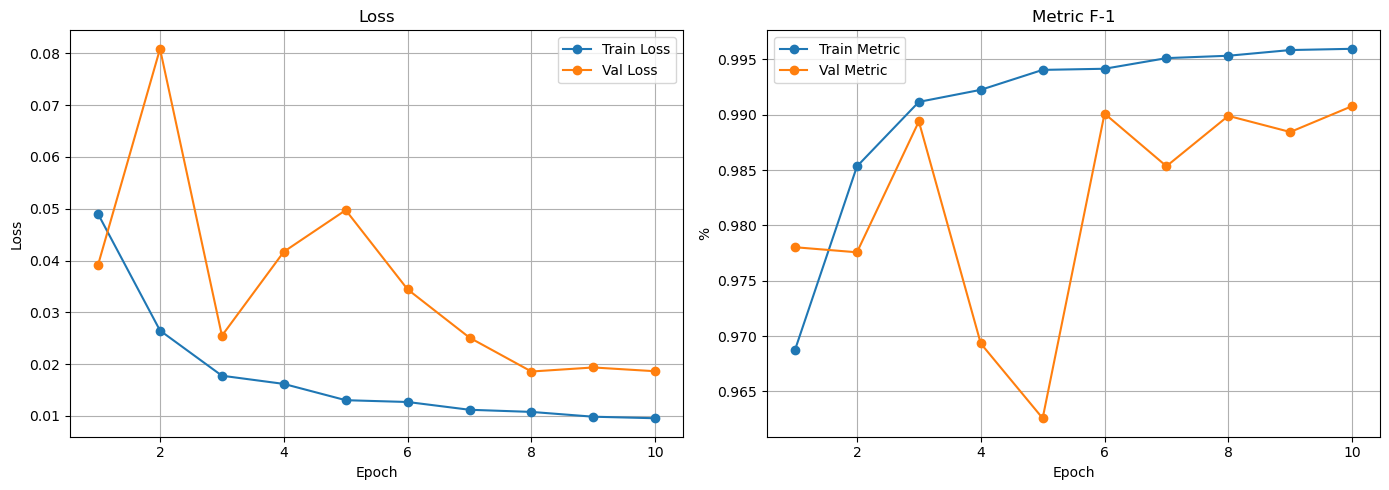

In [89]:
epochs = len(train_loss) + 1

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# График Loss
axs[0].plot(range(1, epochs), train_loss, label='Train Loss', marker='o')
axs[0].plot(range(1, epochs), val_loss, label='Val Loss', marker='o')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# График Метрики
axs[1].plot(range(1, epochs), train_metric, label='Train Metric', marker='o')
axs[1].plot(range(1, epochs), val_metric, label='Val Metric', marker='o')
axs[1].set_title('Metric F-1')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('%')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig('metrics_plot15.png', dpi=300) 
plt.show()

In [90]:
torch.save(model.state_dict(), 'bmodel5_weights.pth')
torch.save(model, 'bmodel5_complete.pth')

#### Подбор порогового значения

In [91]:
import torch
from sklearn.metrics import accuracy_score, precision_score, f1_score

all_labels = []
all_outputs = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader: # val_loader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        if outputs.shape[-1] == 1:  
            outputs = outputs.squeeze(dim=1)

        all_labels.append(labels)
        all_outputs.append(outputs)

all_labels = torch.cat(all_labels).cpu().numpy()
all_outputs = torch.cat(all_outputs).cpu().numpy()

In [92]:
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    preds = (all_outputs >= threshold).astype(int)

    acc = accuracy_score(all_labels, preds)
    precision = precision_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)
    rec = recall_score(all_labels, preds)

    print(f"Threshold {threshold}: Accuracy={acc:.4f}, Precision={precision:.4f}, F1={f1:.4f}, Recall={rec:.4f}")

Threshold 0.5: Accuracy=0.9902, Precision=0.9977, F1=0.9909, Recall=0.9842
Threshold 0.6: Accuracy=0.9897, Precision=0.9981, F1=0.9904, Recall=0.9828
Threshold 0.7: Accuracy=0.9891, Precision=0.9981, F1=0.9898, Recall=0.9817
Threshold 0.8: Accuracy=0.9883, Precision=0.9981, F1=0.9890, Recall=0.9802
Threshold 0.9: Accuracy=0.9878, Precision=0.9984, F1=0.9885, Recall=0.9788
Threshold 0.95: Accuracy=0.9874, Precision=0.9984, F1=0.9882, Recall=0.9783


Ошибочная классификация занятых мест как пустых рушит цель проекта (и вызовет гнев пользователей). Поэтому максимизируем precision при более менее оптимальных других метриках точности.  
Для 4 модели Возьмем порог 0.8  
Для других 0.9

#### А теперь проверим модель на тестовых данных

In [104]:
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_dataset = datasets.ImageFolder(r"C:\Users\kalmy\Documents\Machine learning\PKLot_Dataset\create data\Данные\B test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

model.eval()
y_true, y_pred = [], []

# Хранилище ошибок
wrong_images = []
wrong_preds = []
wrong_labels = []

with torch.no_grad(): # Без вычисления градиентов
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        #preds = torch.argmax(outputs, dim=1)
        preds = (torch.sigmoid(outputs) > 0.95).int() # for binary

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        
        for img, pred, label in zip(imgs, preds, labels):
            if pred.item() != label.item():
                wrong_images.append(img.cpu())
                wrong_preds.append(pred.item())
                wrong_labels.append(label.item())

print("Classification Report on test:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report on test:
              precision    recall  f1-score   support

    occupied       0.94      0.95      0.95      3621
       empty       0.93      0.92      0.92      2550

    accuracy                           0.94      6171
   macro avg       0.93      0.93      0.93      6171
weighted avg       0.94      0.94      0.94      6171



#### А поточнее

In [105]:
print("Accuracy = ", accuracy_score(y_true, y_pred))
print("F-1 мера = ", f1_score(y_true, y_pred))
print("Precision = ", precision_score(y_true, y_pred))
print("Recall = ", recall_score(y_true, y_pred))

Accuracy =  0.9358288770053476
F-1 мера =  0.9219550650374458
Precision =  0.9267036450079239
Recall =  0.9172549019607843


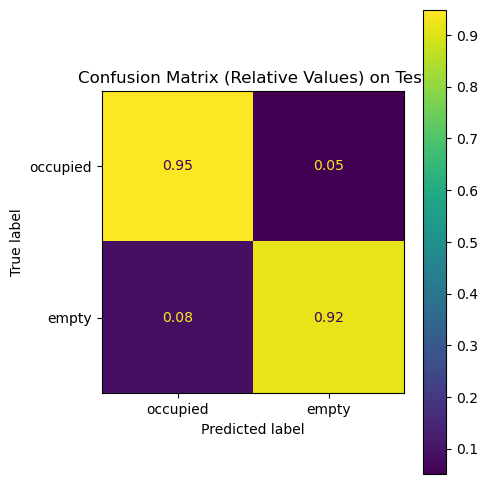

In [106]:
cm = confusion_matrix(y_true, y_pred)
cm_relative = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_relative, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, values_format='.2f')  # Форматируем значения с двумя знаками после запятой
plt.title("Confusion Matrix (Relative Values) on Test")
plt.tight_layout()

plt.savefig('conf_matrix_relative15.png', dpi=300, bbox_inches='tight')
plt.show()


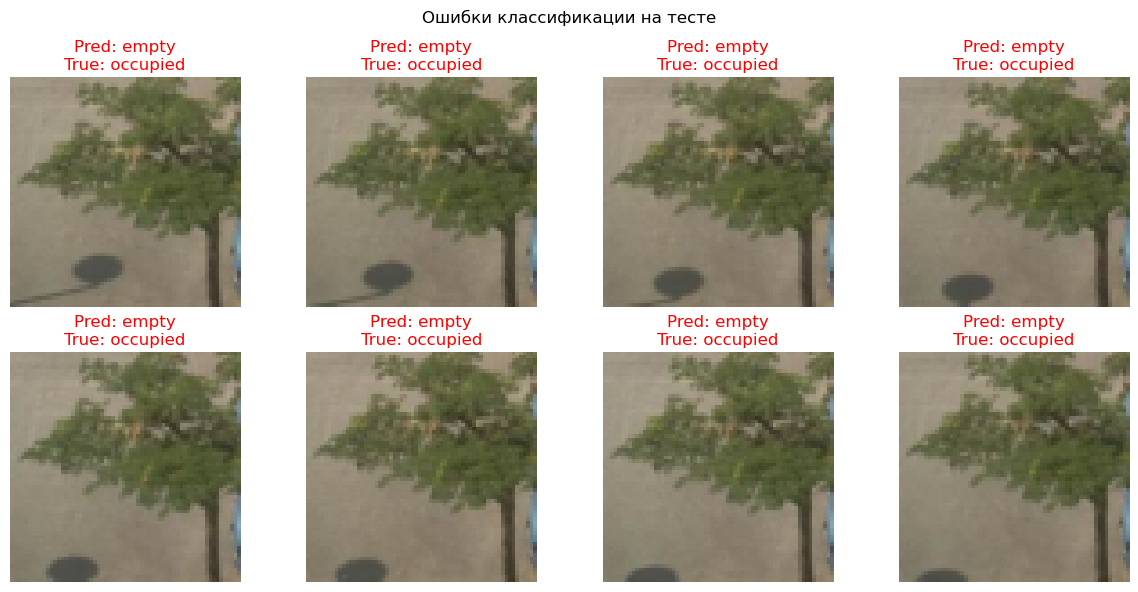

In [41]:
# Визуализация первых N ошибок
N = 8

# Функция для отмены нормализации
def denormalize(tensor, mean, std):
    for i in range(3):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

plt.figure(figsize=(12, 6))
for i in range(min(N, len(wrong_images))):
    img = wrong_images[i+250]
    img = denormalize(img.clone(), mean, std)
    pred = class_names[wrong_preds[i]]
    label = class_names[wrong_labels[i]]

    plt.subplot(2, 4, i + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(f"Pred: {pred}\nTrue: {label}", color='red')
    plt.axis("off")
plt.suptitle("Ошибки классификации на тесте")
plt.tight_layout()
plt.show()

In [47]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

def make_prediction(img_path):
    image = Image.open(img_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        #predicted_class = torch.argmax(output, dim=1).item()
        predicted_class = (torch.sigmoid(output) > 0.8).int() # for binary
    print(f"Модель предсказала класс: {class_names[predicted_class]}")

In [48]:
for i in range(1, 7):
    img_path = r"C:\Users\kalmy\Documents\Machine learning\доп картинки\empty_lot" + str(i)+".png"
    make_prediction(img_path)
print("_"*40)
for i in range(1, 7):
    img_path = r"C:\Users\kalmy\Documents\Machine learning\доп картинки\occupied_lot" + str(i)+".png"
    make_prediction(img_path)

Модель предсказала класс: empty
Модель предсказала класс: empty
Модель предсказала класс: empty
Модель предсказала класс: empty
Модель предсказала класс: empty
Модель предсказала класс: empty
________________________________________
Модель предсказала класс: occupied
Модель предсказала класс: occupied
Модель предсказала класс: occupied
Модель предсказала класс: occupied
Модель предсказала класс: occupied
Модель предсказала класс: occupied


#### Сохраняем веса модели

In [199]:
torch.save(model.state_dict(), 'bmodel3_weights.pth')

#### Если нужно загрузить модель

In [20]:
model = SmallCNN()
state_dict = torch.load("bmodel3_weights.pth", weights_only=True)
model.load_state_dict(state_dict)
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)